# Correlation of MAMCOD p-values

This is to figure out whether MAMCOD p-values are Positively Correlated

### Setup

In [7]:
# This helps when you're loading functions defined in an external script (if the script is updated while the notebook is running)
%load_ext autoreload 
%autoreload 2

import numpy as np
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from sklearn.decomposition import PCA
from math import sqrt
from sklearn.preprocessing import StandardScaler

import sys
sys.path.append("..")

from mypackage.data_models import generate_data_uniform_plus_normal_Kclasses
from mypackage.MAMCOD_conformal_procedure import compute_standard_conformal_scores, compute_MAMCOD_conformal_pv

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Parameters

In [8]:
np.random.seed(100)
# Generate data
K = 2
dim = 50
means = [1, -1]
radius= 4
a_signal=2
 
num_iterations= 100 #total times of repeating
num_repeats = 5

# Training data
n_in_train = [1000,1000]

# Calibration data
n_in_cal = [5000,5000]

# Test data
n_in_test = [2,2]
n_out_test = 0
n_test = np.sum(n_in_test) + n_out_test

In [9]:
# Define machine learning models
from sklearn.svm import SVC, OneClassSVM
from sklearn.ensemble import RandomForestClassifier

binary_classifier = SVC(C=1, probability=True)
oneclass_classifier = OneClassSVM(gamma='auto')
classifier_callable = lambda: OneClassSVM(gamma='auto')

## Compute Correlation

In [10]:
# To store correlations for each pair of test data across iterations
all_correlations = []

# Perform num_iterations
for _ in range(num_iterations):
    # Initialize matrix to store p-values for each repetition
    MAMCOD_pv_matrix = np.zeros((num_repeats, n_test))

    # Repeat the procedure and combine results into a matrix
    for i in range(num_repeats):
        # Data Generation
        X_train, Y_train = generate_data_uniform_plus_normal_Kclasses(K, n_in_train, 0, dim, means, radius, a_signal)
        X_cal, Y_cal = generate_data_uniform_plus_normal_Kclasses(K, n_in_cal, 0, dim, means, radius, a_signal)
        X_test, Y_test = generate_data_uniform_plus_normal_Kclasses(K, n_in_test, n_out_test, dim, means, radius, a_signal)

        # Compute the conformity scores
        scores_cal, scores_test = compute_standard_conformal_scores(X_train, Y_train, X_cal, Y_cal, X_test, classifier_callable) #scores_test is a m*K matrix

        # Compute MAMCOD pv
        MAMCOD_pv_matrix[i, :] = compute_MAMCOD_conformal_pv(K, n_in_cal, scores_cal, scores_test)
        print(f'Repeating times: {i}, Iteration times: {_}')
        print(MAMCOD_pv_matrix[i, :])
        
    # Compute the covariance matrix
    cov_matrix = np.cov(MAMCOD_pv_matrix.T)

    # Collect correlations for each pair of test data points
    all_correlations.append(cov_matrix[np.triu_indices_from(cov_matrix, k=1)])

# Combine all correlations into a single array for boxplot
all_correlations = np.array(all_correlations).T

Repeating times: 0, Iteration times: 0
[0.35372925 0.07658468 0.32293541 0.63147371]
Repeating times: 1, Iteration times: 0
[0.82663467 0.48630274 0.16456709 0.99280144]
Repeating times: 2, Iteration times: 0
[0.29174165 0.03519296 0.63167367 0.73065387]
Repeating times: 3, Iteration times: 0
[0.73305339 0.11577684 0.22055589 0.75644871]
Repeating times: 4, Iteration times: 0
[0.10677864 0.42971406 0.99020196 0.5164967 ]
Repeating times: 0, Iteration times: 1
[0.99640072 0.95320936 0.10917816 0.09998   ]
Repeating times: 1, Iteration times: 1
[0.83743251 0.27314537 0.62587483 0.87862428]
Repeating times: 2, Iteration times: 1
[0.86442711 0.15456909 0.80183963 0.22715457]
Repeating times: 3, Iteration times: 1
[0.70565887 0.47790442 0.35612877 0.26054789]
Repeating times: 4, Iteration times: 1
[0.5744851  0.90361928 0.45770846 0.12137572]
Repeating times: 0, Iteration times: 2
[0.06238752 0.70785843 0.20175965 0.60567886]
Repeating times: 1, Iteration times: 2
[0.02719456 0.67826435 0.2

## BoxPlot

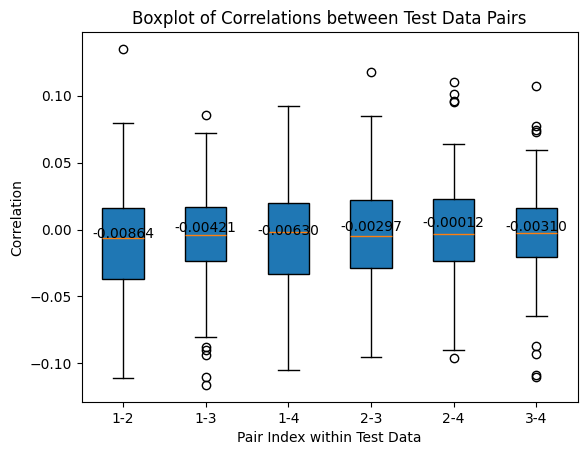

In [11]:
## Generate labels for each pair of test data points
pair_labels = [f'{i+1}-{j+1}' for i in range(n_test) for j in range(i + 1, n_test)]

# Plot a boxplot of the correlations
plt.boxplot(all_correlations.T, vert=True, patch_artist=True)
plt.title('Boxplot of Correlations between Test Data Pairs')
plt.xlabel('Pair Index within Test Data')
plt.xticks(ticks=range(1, len(pair_labels) + 1), labels=pair_labels)
plt.ylabel('Correlation')

# Add mean values as points or text
for i, pair_corr in enumerate(all_correlations):
    mean_value = np.mean(pair_corr)
    plt.text(i + 1, mean_value, f'{mean_value:.5f}', ha='center', va='bottom', color='black', fontsize=10)   
    
plt.show()

In [6]:
enumerate(all_correlations)

In [225]:
# # Plot the conformity scores
# rcParams['figure.figsize'] = 11.7,8.27

# sns.histplot(x=MAMCOD_pv, hue=Y_test, bins=50)
# plt.show()